In [1]:
# don't print tf warning
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)


import os
import pickle
import joblib


import numpy as np
np.random.seed(42)

import scipy
from scipy.ndimage import zoom
import skimage
from skimage.color import rgb2gray
from skimage.feature import hog


import sklearn
from sklearn.manifold import TSNE
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import RobustScaler, FunctionTransformer
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


import keras
from keras.layers import Input
from keras.applications.inception_v3 import InceptionV3, preprocess_input
import keras.backend as K


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Using TensorFlow backend.


In [2]:
import sys

print('Environment specification:\n')
print('python', '%s.%s.%s' % sys.version_info[:3])

for mod in np, scipy, skimage, sklearn, keras:
    print(mod.__name__, mod.__version__)

Environment specification:

python 3.6.4
numpy 1.14.0
scipy 1.0.0
skimage 0.13.1
sklearn 0.19.1
keras 2.1.2


# CIFAR10 dataset

In this exercise we'll create a set of predictive models for the [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset. The dataset consists of 60k images (50k in the training set and 10k in the test set) of 10 classes:
* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck

Note, that I created this notebook on a quite strong machine, so I didn't need to worry about computational load or memory usage. You should use only a fraction of the dataset and reduce the number of jobs running in parallel if you're running this code on a "standard" desktop computer.

In [3]:
def load_cifar_batch(file_path):
    """Load CIFAR10 batch
    
    Arguments
    ---------
    file_path: str
        Path to a file with pickled batch
        
    Returns
    -------
    img_array: np.ndarray, shape (10000, 32, 32, 3)
        32x32 RGB images (colors coded as 0-255)
    labels: np.ndarray, shape (10000,)
        Image labels (numbers 0-9)
    """

    with open(file_path, 'rb') as f:
        data_dict = pickle.load(f, encoding='bytes')
    img_array = data_dict[b'data'].reshape((-1, 3, 32, 32)).transpose((0, 2, 3, 1))
    return img_array, np.array(data_dict[b'labels'])


def load_cifar10():
    """Load whole CIFAR10 dataset. If it is not present in a working directory,
    it will be downloaded.
    
    Returs
    ------
    (X_train, y_train): tuple of np.ndarrays, shapes (50000, 32, 32, 3) and (50000,)
        Images and labels in the training set
    (X_test, y_test): tuple of np.ndarrays, shapes (10000, 32, 32, 3) and (10000,)
        Images and labels in the test set
    classes_name: list of strings
        Names of image classes
    """

    cifar10_path = 'cifar-10-batches-py'
    if not os.path.isdir(cifar10_path):
        ! wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
        ! tar xvzf cifar-10-python.tar.gz; rm cifar-10-python.tar.gz
    
    X_train = []
    y_train = []
    for batch_num in range(1, 6):
        file_path = os.path.join(cifar10_path, 'data_batch_%s' % batch_num)
        batch_images, batch_labels = load_cifar_batch(file_path)
        X_train.append(batch_images)
        y_train.append(batch_labels)

    file_path = os.path.join(cifar10_path, 'test_batch')
    X_test, y_test = load_cifar_batch(file_path)

    with open(os.path.join(cifar10_path, 'batches.meta'), 'rb') as f:
        meta = pickle.load(f, encoding='bytes')
    classes_names = [label.decode() for label in meta[b'label_names']]

    return (np.concatenate(X_train, axis=0), np.concatenate(y_train, axis=0)), (X_test, y_test), classes_names

In [4]:
def get_random_examples(num_per_class=100):
    """Select 10xnum_per_class random examples from the training set. This function returns
    indices sorted by class (num_per_class examples from the class 0, then num_per_class
    examples from the class 1 etc)
    """

    indices = []
    for label_code in range(10):
        class_indices = np.random.choice(np.where(y_train == label_code)[0], num_per_class, replace=False)
        indices.append(class_indices)
    return np.concatenate(indices)

---

In [5]:
(X_train, y_train), (X_test, y_test), image_classes = load_cifar10()

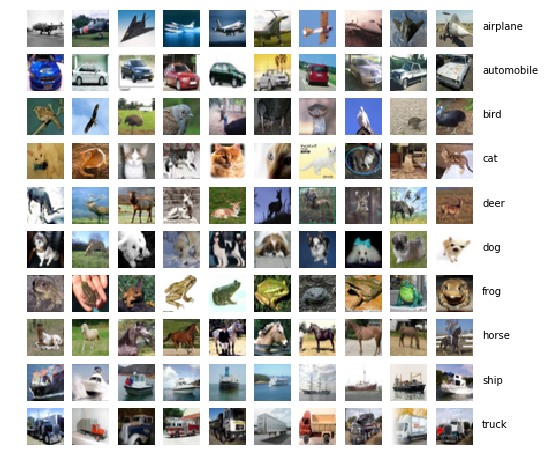

In [6]:
examples100 = get_random_examples(num_per_class=10)

fig, axs = plt.subplots(10, 10, figsize=(8, 8))

for label_code, label_name in enumerate(image_classes):

    img_indices = examples100[10*label_code:10*(label_code + 1)]
    axs[label_code, -1].text(40, 16, label_name)
    for ax, img in zip(axs[label_code], X_train[img_indices]):
        ax.imshow(img)
        ax.set_axis_off()

In [7]:
# we'll later need a bigger set of examples
examples5000 = get_random_examples(500)

# Shallow classifier

First we'll try a classical approach. We'll calculate HoG descriptors for the images and build an SVM on top of them. This model will serve as a benchmark for the deep models we'll build later.

In [8]:
def get_hog(img_array, block_norm='L2-Hys'):
    """Caclucate HoG descriptors for an array of images. This function uses skimage implementation,
    which does not support RGB images, so they will be converted to grayscale.
    """

    return np.array([hog(rgb2gray(img), block_norm=block_norm) for img in img_array])

In [9]:
hog_descriptors = get_hog(X_train)

Let's first analyze the descriptors for some example images. We'll take a look at their distribution and visualize them in 2D using t-SNE.

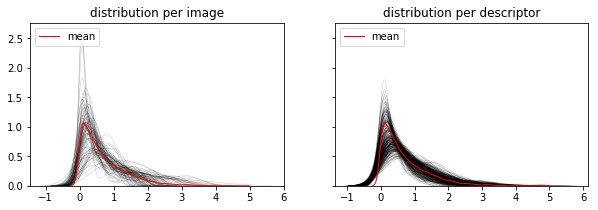

In [10]:
hog_examples = hog_descriptors[examples100]

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 3), sharey=True)

for ax, array, title in ((ax1, hog_examples, 'per image'), (ax2, hog_examples.T, 'per descriptor')):
    for row in array:
        sns.kdeplot(row, color='black', linewidth=0.5, alpha=0.2, ax=ax)
    sns.kdeplot(array.flatten(), color='r', linewidth=1, ax=ax, label='mean')
    ax.set_title('distribution ' + title)
    ax.legend(loc='upper left');

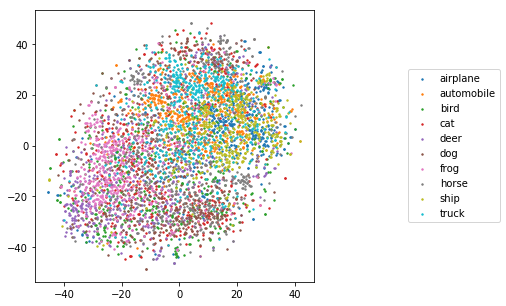

In [11]:
tsne = TSNE()
tsne_res = tsne.fit_transform(hog_descriptors[examples5000])


fig, ax = plt.subplots(figsize=(5, 5))

for label_code, label_name in enumerate(image_classes):
    i = 500*label_code
    j = 500*(label_code+1)
    ax.scatter(tsne_res[i:j, 0], tsne_res[i:j, 1], label=label_name, s=2)

ax.legend(loc='center', bbox_to_anchor=(1.5, 0.5));

The classes don't look easily separable, so we might need to use the kernel trick. We'll start with a simple linear SVM and then try a Gaussian kernel and check whether it improves accuracy, and if this improvement compensates increase in model's complexity and training time. For both models we'll create a `Pipeline` with `RobustScaler` to standardize the values of the HoG descriptors.

Also, we'll try to tune the hyperparameters (`gamma` and\or `C`). For this purpose we'll use `RandomizedSearchCV` with 3-fold cross-validation on 1/10 of the dataset (to speed up the computations). Note that the value we'll find might not be the optimal one for the whole dataset, but it should be good enought.

## Linear SVM

In [12]:
hog_svm_pipe = Pipeline([
    ('scaler', RobustScaler()),
    ('svm', LinearSVC())
])

In [13]:
hog_random_search = RandomizedSearchCV(
    hog_svm_pipe,
    {'svm__C': np.logspace(-5, 5, num=100)},
    n_iter=50,
    n_jobs=20,
    verbose=1
)

hog_random_search.fit(hog_descriptors[examples5000], y_train[examples5000]);

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    7.1s
[Parallel(n_jobs=20)]: Done 150 out of 150 | elapsed:  3.5min finished


In [14]:
hog_random_search.best_score_

0.4432

In [15]:
hog_svm_pipe = hog_random_search.best_estimator_

In [16]:
cross_val_score(hog_svm_pipe, hog_descriptors, y_train, n_jobs=-1)

array([0.48494301, 0.48746251, 0.48667467])

Let's now train the model on the whole training set and add preprocessing setps to the pipeline, so it will operate on raw CIFAR10 images and calucalte descriptors on the fly (it will be more useful for prediction and for future use in general).

In [17]:
hog_svm_pipe.fit(hog_descriptors, y_train)
new_steps = [('hog_transformer', FunctionTransformer(func=get_hog, validate=False))] + hog_svm_pipe.steps
hog_svm_pipe = Pipeline(new_steps)

In [18]:
hog_svm_pipe.score(X_test, y_test)

0.4824

In [19]:
with open('hog_svm_linear.pkl', 'wb') as f:
    pickle.dump(hog_svm_pipe, f)

The model generalizes nicely and we get a similar performance on the test set. Model's accuracy, however, is quite low so we'll try to improve it by using a Gaussian (`rbf`) kernel.

## SVM with Gaussian kernel

In [20]:
hog_rbf_pipe = Pipeline([
    ('scaler', RobustScaler()),
    ('svm', SVC(kernel='rbf'))
])

In [21]:
hog_random_search = RandomizedSearchCV(
    hog_rbf_pipe,
    {'svm__C': np.logspace(-5, 5, num=100), 'svm__gamma': np.logspace(-5, 5, num=100)},
    n_iter=100,
    n_jobs=20,
    verbose=1
)

hog_random_search.fit(hog_descriptors[examples5000], y_train[examples5000]);

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:   21.1s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:  3.0min
[Parallel(n_jobs=20)]: Done 300 out of 300 | elapsed:  5.6min finished


In [22]:
hog_random_search.best_score_

0.464

In [23]:
hog_rbf_pipe = hog_random_search.best_estimator_

In [24]:
cross_val_score(hog_rbf_pipe, hog_descriptors, y_train, n_jobs=-1)

array([0.59208158, 0.58884223, 0.5879952 ])

There is a notable improvement, but there is also a substantial increase in training time.
Again we'll train the model on the whole training set, add preprocessing setps to the pipeline, and evaluate the model on the test set.

In [25]:
hog_rbf_pipe.fit(hog_descriptors, y_train)
new_steps = [('hog_transformer', FunctionTransformer(func=get_hog, validate=False))] + hog_rbf_pipe.steps
hog_rbf_pipe = Pipeline(new_steps)

In [26]:
hog_rbf_pipe.score(X_test, y_test)

0.6104

In [27]:
with open('hog_svm_rbf.pkl', 'wb') as f:
    pickle.dump(hog_rbf_pipe, f)

# Deep classifier

We'll now create a more sophisticated classifier. We'll use [Inception V3](https://arxiv.org/abs/1512.00567) trained on [ImageNet](http://www.image-net.org/) to featurize images, and again we'll build an SVM model on top of the features.
We'll use [Keras implementation](https://keras.io/applications/#inceptionv3) to build the model and load the weights.

When looking for the most appropriate layer to use, we'll focus on hidden layers close to the network's output, because the task we're trying to solve is fairly similar to the one Inception was trained for.
We'll experiment with 3 feature vectors extracted from the network: activations after the final pooling (`avg_pool`, just before the softmax layer) and two previous concatenation layers (`mixed9` and `mixed10`).

Inception V3 requires images of size 139x139 or bigger, so we'll need to upscale the images. Also, pixel intensities need to be standardized to the (-1, 1) range, so we'll use `preprocess_input` from `inception_v3` submodule to prepare them.

## CNN codes

In [28]:
cnn_input_size = 139
image_size = X_train.shape[1]

scale = cnn_input_size / image_size

In [29]:
input_image = Input(shape=(cnn_input_size, cnn_input_size, 3))
inception_model = InceptionV3(include_top=True, weights='imagenet', input_tensor=input_image)

layer_names = []
layers = []

for layer in inception_model.layers:
    if layer.name in ('avg_pool', 'mixed10', 'mixed9'):
        layers.append(layer)
        layer_names.append(layer.name)
          

activations_func = K.function([input_image, K.learning_phase()],
                              [layer.output for layer in layers])

In [30]:
def process_image(image):
    return preprocess_input(zoom(image, (scale, scale, 1)).astype(np.float32))

Computing the activation will take a while and requires a lot of memory, especially if you don't have a GPU. Also, hyperparameter search is computationally intensive and can take several hours. You can skip this part, run cell no. [41](#cnn_codes_cell) and then go straight to the [trained model](#Best-model).

In [31]:
prepared_images = np.array(
    joblib.Parallel(n_jobs=-1, verbose=1)(
        joblib.delayed(process_image)(xi) for xi in X_train
    )
)

[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1352 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 2752 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 4552 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 6752 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done 9352 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done 12352 tasks      | elapsed:   38.2s
[Parallel(n_jobs=-1)]: Done 15752 tasks      | elapsed:   48.5s
[Parallel(n_jobs=-1)]: Done 19552 tasks      | elapsed:   60.0s
[Parallel(n_jobs=-1)]: Done 23752 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 28352 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 33352 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 38752 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 44552 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 50000 out of 50000 | elapsed:  2.5min finished


In [32]:
batch_size = 200

cnn_codes = []

for img_batch in np.split(prepared_images, range(batch_size, len(prepared_images), batch_size)):
    cnn_codes.append(activations_func([img_batch, 0]))

cnn_codes = [np.concatenate(codes, axis=0).reshape(len(prepared_images), -1) for codes in zip(*cnn_codes)]

In [33]:
for name, codes in zip(layer_names, cnn_codes):
    print(name, codes.shape)

mixed9 (50000, 18432)
mixed10 (50000, 18432)
avg_pool (50000, 2048)


## Differences between the layers

Let's take a look at the three feature vectors we extracted. As in case of HoG descriptors, we'll analyze their distribution and visualize their 2D embeddings using t-SNE.

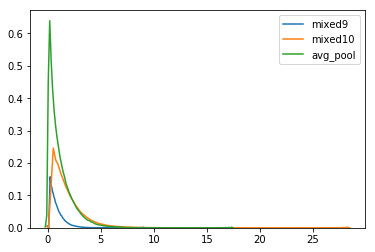

In [34]:
for name, codes in zip(layer_names, cnn_codes):
    sns.kdeplot(codes[examples100].flatten(), label=name)
plt.legend();

In [35]:
tsne = TSNE()

tsne_results = joblib.Parallel(n_jobs=-1)(
    joblib.delayed(tsne.fit_transform)(codes[examples5000])
    for codes in cnn_codes
)

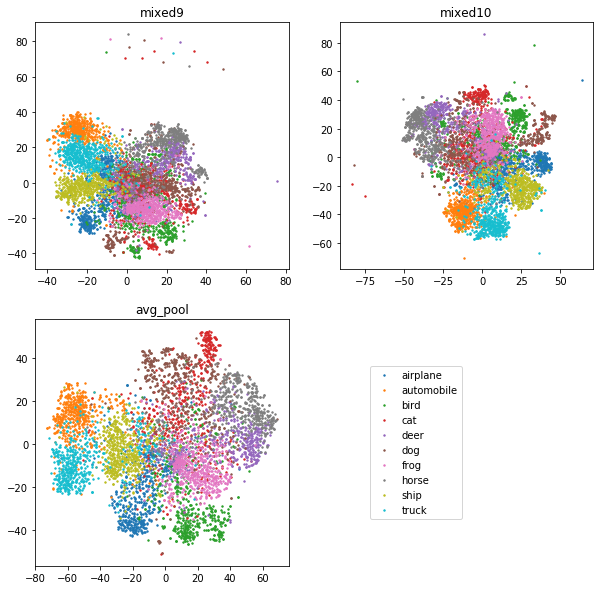

In [36]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()

for name, tsne_result, ax in zip(layer_names, tsne_results, axs):
    ax.set_title(name)

    for label_code, label_name in enumerate(image_classes):
        i = 500*label_code
        j = 500*(label_code+1)
        ax.scatter(tsne_result[i:j, 0], tsne_result[i:j, 1], label=label_name, s=2)
axs[-1].set_visible(False)
axs[-2].legend(loc='center', bbox_to_anchor=(1.5, 0.5));

All three layers look promising and at this point it's hard to judge which one would be the best. We'll try to build a linear SVM for each and select the best one. Then we'll see if some performance gain is possible with Gaussian kernel.

Again, we'll use random search with 3-fold cross-validation on 1/10 of the dataset to select hyperparameters.

In [37]:
cnn_svm_pipe = Pipeline([
    ('scaler', RobustScaler()),
    ('svm', LinearSVC())
])

cnn_random_search = RandomizedSearchCV(
    cnn_svm_pipe,
    {'svm__C': np.logspace(-5, 5, num=100)},
    n_iter=50,
    n_jobs=20,
    verbose=1
)

In [38]:
estimators = []

for name, codes in zip(layer_names, cnn_codes):
    cnn_random_search.fit(codes[examples5000], y_train[examples5000])
    print(name, 'cv score on 1/10:', cnn_random_search.best_score_)
    estimators.append(cnn_random_search.best_estimator_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:  5.7min
[Parallel(n_jobs=20)]: Done 150 out of 150 | elapsed: 51.1min finished


mixed9 cv score on 1/10: 0.7276
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:  8.5min
[Parallel(n_jobs=20)]: Done 150 out of 150 | elapsed: 70.6min finished


mixed10 cv score on 1/10: 0.8208
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:   15.8s
[Parallel(n_jobs=20)]: Done 150 out of 150 | elapsed:  1.7min finished


avg_pool cv score on 1/10: 0.826


`mixed10` and `avg_pool` layers give comparable results, but the latter produce 9 times shorter feature vector, so we'll use it in our model.

In [39]:
cnn_svm_pipe = estimators[2]
cross_val_score(cnn_svm_pipe, cnn_codes[2], y_train, n_jobs=-1)

array([0.86064787, 0.85692861, 0.85312125])

In [40]:
cnn_svm_pipe.fit(cnn_codes[2], y_train)

Pipeline(memory=None,
     steps=[('scaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('svm', LinearSVC(C=0.00032745491628777284, class_weight=None, dual=True,
     fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
     max_iter=1000, multi_class='ovr', penalty='l2', random_state=None,
     tol=0.0001, verbose=0))])

<a id='cnn_codes_cell'></a>

In [41]:
def get_cnn_codes(img_array, batch_size=200, scale=139/32):
    """Calculates CNN codes (activations on the last hidden layer of Inception V3)
    for CIFAR10 images"""
    cnn_codes_func = K.function([input_image, K.learning_phase()], [layers[2].output])
    
    cnn_codes = []
    for img_batch in np.split(img_array, range(batch_size, len(img_array), batch_size)):
        img_batch = np.array([process_image(image) for image in img_batch])
        cnn_codes.append(cnn_codes_func([img_batch, 0])[0])

    return np.concatenate(cnn_codes, axis=0).squeeze()

In [42]:
new_steps = [('cnn_codes', FunctionTransformer(get_cnn_codes, validate=False))] + cnn_svm_pipe.steps

cnn_svm_pipe = Pipeline(new_steps)

with open('cnn_svm_linear.pkl', 'wb') as f:
    pickle.dump(cnn_svm_pipe, f)

Let's try SVM with Gaussian kernel:

In [43]:
cnn_rbf_pipe = Pipeline([
    ('scaler', RobustScaler()),
    ('svm', SVC(kernel='rbf'))
])

cnn_random_search = RandomizedSearchCV(
    cnn_rbf_pipe,
    {'svm__C': np.logspace(-5, 5, num=100), 'svm__gamma': np.logspace(-5, 5, num=100)},
    n_iter=100,
    n_jobs=20,
    verbose=1
)

cnn_random_search.fit(cnn_codes[2][examples5000], y_train[examples5000]);

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:  2.6min
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed: 21.7min
[Parallel(n_jobs=20)]: Done 300 out of 300 | elapsed: 39.9min finished


In [44]:
cnn_rbf_pipe = cnn_random_search.best_estimator_

In [45]:
cross_val_score(cnn_rbf_pipe, cnn_codes[2], y_train, n_jobs=-1)

array([0.8520096 , 0.85314937, 0.84963986])

In [46]:
new_steps = [('cnn_codes', FunctionTransformer(get_cnn_codes, validate=False))] + cnn_rbf_pipe.steps

cnn_rbf_pipe = Pipeline(new_steps)

with open('cnn_svm_rbf.pkl', 'wb') as f:
    pickle.dump(cnn_rbf_pipe, f)

This time we weren't able to achieve better results with Gaussian kernel, so we'll stick to the simpler model.

# Best model

In [47]:
if 'cnn_svm_pipe' not in globals():
    with open('cnn_svm_linear.pkl', 'rb') as f:
        cnn_svm_pipe = pickle.load(f)

In [48]:
pred_test = cnn_svm_pipe.predict(X_test)

accuracy_score(y_test, pred_test)

0.86

In [49]:
print(classification_report(y_test, pred_test, target_names=image_classes))

             precision    recall  f1-score   support

   airplane       0.86      0.88      0.87      1000
 automobile       0.91      0.92      0.91      1000
       bird       0.87      0.80      0.84      1000
        cat       0.77      0.78      0.77      1000
       deer       0.82      0.83      0.82      1000
        dog       0.85      0.81      0.83      1000
       frog       0.82      0.90      0.86      1000
      horse       0.90      0.87      0.88      1000
       ship       0.90      0.91      0.91      1000
      truck       0.90      0.90      0.90      1000

avg / total       0.86      0.86      0.86     10000



In [50]:
conf_matrix = confusion_matrix(y_test, pred_test)
conf_matrix

array([[879,   8,  20,  10,   4,   2,   8,   5,  53,  11],
       [  9, 917,   2,   8,   2,   2,   1,   1,   9,  49],
       [ 30,   3, 800,  34,  52,   9,  53,   7,   6,   6],
       [ 12,   1,  24, 777,  21,  84,  54,  13,   6,   8],
       [ 10,   0,  28,  22, 827,   7,  54,  44,   7,   1],
       [  6,   4,   9, 101,  24, 814,  15,  25,   1,   1],
       [  5,   1,  18,  32,  20,  14, 902,   3,   3,   2],
       [ 12,   1,   9,  18,  51,  28,   6, 871,   2,   2],
       [ 43,  13,   4,   2,   4,   1,   1,   0, 914,  18],
       [ 14,  60,   2,   7,   2,   0,   3,   2,  11, 899]])

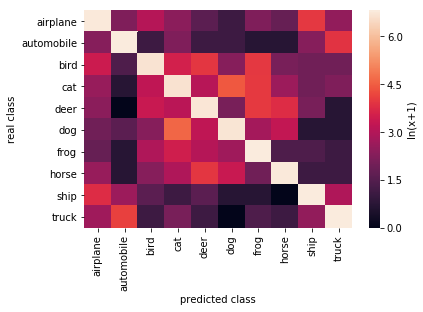

In [51]:
fig, ax = plt.subplots()
sns.heatmap(np.log1p(conf_matrix), xticklabels=image_classes, yticklabels=image_classes,
            cbar_kws={'label': 'ln(x+1)'}, ax=ax)
ax.set_xlabel('predicted class')
ax.set_ylabel('real class');

It seems that the hardest class to predict is `cat`.
Some mistakes made by the model are quite easy to explain: it confuses `automobile` with `truck`, `ship` with `airplane`, `dog` with `cat`, and `deer` with `horse`. These pairs of classes contain similar objects with some common visual features.
What is more surprising, animals are quite frequently predicted to be `frog`.